# [0] Imports

These are modules we need to run the notebook.

In [1]:
using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, Dates, FStrings

# [1] Set Up Parameters

Numbers and parameters necessary for our specific issue. The most important is `n_jobs`, how many job vehicles we have. Coverage will be determined based on the distribution of our jobs.

In [2]:
n_jobs = 40
m_cov = n_jobs
B = n_jobs
V = m_cov
T = 2 * n_jobs
min_duration = 2
max_duration = 6
speed = 500 / 3
radius = 50
size = 500
mesh = 50;

seed = 1042;

# [2] Create Job Parameters

In [3]:
Random.seed!(seed)

function create_cluster_sizes(jobs_total, target_clusters=8)
    # The smaller target_clusters is, the more concentrated the clumps are
    Random.seed!(seed)
    jobs_created = 0
    cluster = []
    min_jobs_allowed = n_jobs >= 15 ? 3 : 2
    target_clusters = 6
        while jobs_created != jobs_total
            num_to_add = rand(min(min_jobs_allowed, jobs_total - jobs_created) : 
                min(Int((n_jobs/target_clusters)÷1), jobs_total - jobs_created))
            jobs_created += num_to_add
            push!(cluster, num_to_add)
        end
    
    return cluster
end;

time_windows = []
locations = rand(Uniform(0,size), 1, 2)
work_load = []
cluster = create_cluster_sizes(n_jobs)

function create_time_windows_and_work_load(cluster_sizes, locations)
    Random.seed!(seed)
    locations = rand(Uniform(0,size), 1, 2)
    for size_c in cluster
        first = rand(Uniform(0,size), 1, 2)
        locations = vcat(locations, first)

        job_begins = rand(2:10)
        job_finish = rand((job_begins+min_duration):(job_begins+max_duration))
        push!(time_windows, [job_begins, job_finish])

        time_work = rand(min_duration:max(min_duration, job_finish - job_begins))
        push!(work_load, time_work)

        for neighbour in 1:(size_c-1)
            deviation = 20 # decide how interspersed/random-radiused the cluster should be
            new_x = rand(Uniform(max(0,first[1]-deviation), min(first[1]+deviation, size)), 1, 1)
            new_y = rand(Uniform(max(0,first[2]-deviation), min(first[2]+deviation, size)), 1, 1)
            new = hcat(new_x, new_y)
            locations = vcat(locations, new)

            job_begins = rand(job_finish:min(T-min_duration-2, job_finish + 6))
            job_finish = rand((job_begins+min_duration):(min(job_begins+max_duration, T-2)))
            push!(time_windows, [job_begins, job_finish])

            time_work = rand(min_duration:min(max_duration, job_finish-job_begins))
            push!(work_load, time_work)
        end
    end
    
    return [time_windows, work_load, locations]
end

time_windows, work_load, locations = create_time_windows_and_work_load(cluster, locations)

function reformat_locations(locations)
    #= The fact that locations[1] gives the same float (not tuple or list)
    as locations[1, 1] and locations[1][2] throws an 
    error is extremely frustrating.
    This function makes locations[1][1] possible, 
    while locations[1] correctly returns a tuple. =#
    locs = []
    for i in 1:Int(length(locations) * 0.5)
        push!(locs, [locations[i,1], locations[i,2]])
    end
    return locs
end

job_locs = reformat_locations(locations)
push!(job_locs, job_locs[1]);

In [4]:
job_dists = [LinearAlgebra.norm(job_locs[i] .- job_locs[j]) for i=1:n_jobs+2, j = 1:n_jobs+2];

In [5]:
job_travel_times = ceil.(job_dists / speed);

# [3] Create Coverage Parameters

In [6]:
create_all_valid_spots = true;

In [7]:
function is_close_enough(coverage_loc, job_loc)
    #= Given a coverage_loc with 2 elements x y
    and a job_loc with two elements x y
    determines if that specific job_loc is located within r 
    of the coverage_loc as the crow flies =#
    return (coverage_loc[1]-job_loc[1])^2 + (coverage_loc[2]-job_loc[2])^2 <= radius^2
end;

function close_enough_jobs(coverage_loc)
    jobs = []
    for i in 1:n_jobs
        if is_close_enough(coverage_loc, job_locs[i+1])
            push!(jobs, i)
        end
    end
    return jobs
end;

In [8]:
cov_locs = []
seen = []

for x in 0:mesh:size
    for y in 0:mesh:size
        potential_cov = [x, y]
        useful = false
        
        if create_all_valid_spots
            for index in 2:length(job_locs)-1
                if is_close_enough(potential_cov, job_locs[index])
                    useful = true
                    break
                end
            end
        else
            for job in close_enough_jobs(potential_cov)
                if ~(job in seen)
                    push!(seen, job)
                    useful = true
                end
            end
        end
        
        if useful
            push!(cov_locs, potential_cov)
        end
    end
end;

In [9]:
m_cov = length(cov_locs);
V = m_cov;

In [10]:
insert!(cov_locs, 1, job_locs[1])
push!(cov_locs, cov_locs[1]);

In [11]:
cov_dists = [LinearAlgebra.norm(cov_locs[i] .- cov_locs[j]) for i=1:m_cov+2, j = 1:m_cov+2];

In [12]:
cov_travel_times = ceil.(cov_dists / speed);

# [4] Create Initial Job Routes

In [13]:
job_routes = []

for i in 1:n_jobs
    route = []
    dist = job_dists[0+1, i+1]
    
    start_going_time = Int(floor(time_windows[i][1] - dist/speed))
    # time_arrival = time_windows[i][1]
    # time_finished = time_windows[i][2]
    finish_time = time_windows[i][2]
    return_finished = Int(ceil(finish_time + dist/speed))
    
    push!(route, [[0, start_going_time], [i, time_windows[i][1]], dist])
    
    for working in time_windows[i][1]:(finish_time-1)
        push!(route, [[i, working], [i, working+1], 0])
    end
    
    push!(route, [[i, finish_time], [n_jobs+1, return_finished], dist])
    push!(job_routes, route)
end;

# [5] Create Initial Coverage Routes

In [14]:
cov_routes = []

for j in 1:m_cov
    route = []
    dist = cov_dists[0+1, j+1]
    
    arrive_time = Int(ceil(dist/speed))
    leave_time = Int(T+1 - ceil(dist/speed))
    
    push!(route, [[0, 0], [j, arrive_time], dist])

    for t in arrive_time:leave_time-1
        push!(route, [ [j, t], [j, t+1], 0])
    end
    
    push!(route, [[j, leave_time], [m_cov+1, T+1], dist])
    push!(cov_routes, route)
end;

# [6] Helper Functions

## [6.1] Compute cost of route

In [15]:
function route_cost(route)
    ans = 0
    for arc in route
        ans += arc[3]
    end
    return ans
end;

## [6.2] Compute $u_i^q$

In [16]:
function compute_u(routes)
    Q = length(routes)
    u = [[0 for q in 1:Q] for i in 1:n_jobs]
    
    for rindex in 1:Q
        route = routes[rindex]
        for arc in route
            loc1 = arc[1][1]
            loc2 = arc[2][1]
            if (1 <= loc1 <= n_jobs)
                u[loc1][rindex] = 1
            end
            if (1 <= loc2 <= n_jobs)
                u[loc2][rindex] = 1
            end
        end
    end
    return u
end;

## [6.3] Compute $\delta_{it}^q$

In [17]:
function compute_delta(routes)
    Q = length(routes)
    delta = [[[0.0 for q in 1:Q] for t in 1:T] for i in 1:n_jobs]
    for rindex in 1:Q
        route = routes[rindex]
        for arc in route
            loc1, time1 = arc[1]
            loc2, time2 = arc[2]
            if (loc1 != 0) & (loc1 != n_jobs + 1)
                delta[loc1][time1][rindex] = 1
            end
            
            if (loc2 != 0) & (loc2 != n_jobs + 1)
                delta[loc2][time2][rindex] = 1
            end
        end
    end
    return delta
end;

## [6.4] Compute $y_{jt}^p$

In [18]:
function compute_y(routes)
    y = [[[0 for p in 1:length(routes)] for t in 1:T] for j in 1:m_cov]
    
    for rindex in 1:length(routes)
        route = routes[rindex]
        for arc in route
            job1, time1 = Int.(arc[1])
            job2, time2 = Int.(arc[2])
            if job1 != 0
                y[job1][time1][rindex] = 1
            end
            if job2 != m_cov + 1
                y[job2][time2][rindex] = 1
            end
        end
    end
    return y
end;

## [6.5] Compute $L_{ji}$

In [19]:
function compute_L(cov_locs, job_locs)
    #= Given a list of tuple coverage locations and job locations,
    returns a matrix of L values. Specifically, 
    L[j][i], indicating if spot j is close enough to node i
    for coverage to happen. We might have to delete padding of depot
    first. =#
    L = []
    for j in 2:length(cov_locs)-1
        L_j = []
        cov_loc = cov_locs[j] # padding accounted for
        for i in 2:length(job_locs)-1
            push!(L_j, is_close_enough(cov_loc, job_locs[i]) ? 1 : 0)
        end
        push!(L, L_j)
    end
    
    return L
end;

## [6.6] Compute $W_{it}$

In [20]:
function compute_W(job_routes)
    #=
    Given the full solution routes to the job problem,
    tells us W[i][t], which is whether job i is being
    done at time t.
    
    Our strategy is to gather the FIRST node of each arc,
    because it's the same as the second node of the arc prior.
    
    Disregard the 1st node (its start is the origin-depot), 
    that information is contained in the 2nd node.
    =#
    W = [ [0 for t in 1:T] for i in 1:n_jobs]
    
    for route in job_routes
        for arc in route[2:end]
            loc = Int(arc[1][1])
            time = Int(arc[1][2])
            W[loc][time] = 1
        end
    end
    
    return W
end;   

## [6.7] Compute $j$'s Neighborhood

In [21]:
function neighborhood(j)
    # returns all nodes i which are close to the spot j.
    cov_loc = cov_locs[j+1] # don't forget padding!
    
    close = []
    for i in 1:n_jobs
        if is_close_enough(cov_loc, job_locs[i+1])
            push!(close, i)
        end
    end
    
    return close
end;

## [6.8] Compute coverage stations close to $i$

In [22]:
function close_covs(i)
    job_loc = job_locs[i+1] # padding included
    close = []
    for j in 1:m_cov
        if is_close_enough(cov_locs[j+1], job_loc)
            push!(close, j)
        end
    end
    return close
end;

## [6.9] Given route, list nodes

In [23]:
function route_to_nodes(route)
    # get only the 1st node of all arcs except the last, when you get the 2nd
    nodes = []
    for arc in route[1:end-1]
        new_node = arc[1][1]
        push!(nodes, new_node)
    end
    push!(nodes, route[end][2][1])
    return unique(nodes)
end;

## [6.10] Given route, list times

In [24]:
function route_to_times(route)
    #= Obtain time "markers" when you leave
    or arrive at any node. This is more convenient
    than just telling me when I arrive at any node.
    If the two nodes in an arc are not equal,
    list both of their times. Otherwise, list neither. =#
    times = []
    for arc in route[1:end]
        n1, t1 = arc[1]
        n2, t2 = arc[2]
        if n1 != n2
            push!(times, t1)
            push!(times, t2)
        end
    end
    return times
end;

## [6.11] Given nodes and times, produce route

In [25]:
function nodes_and_times_to_route(nodes, times, route_type)
    #= Given by two components: When you leave/go between nodes,
    and when you stay. Alternate: start "when you stay",
    then "when you go". For the first node there is no stay. 
    For the last node there is no stay nor go.=#
    route = []
    for i in 1:length(nodes)-1
        
        # WHEN YOU STAY
        if i > 1
            n = Int(nodes[i])
            t1 = Int(times[2*i-2])
            t2 = Int(times[2*i-1])
            
            for t in t1:t2-1
                arc = [[n, t], [n, t+1], 0]
                push!(route, arc)
            end
        end
        
        # WHEN YOU GO
        n1 = Int(nodes[i])
        n2 = Int(nodes[i+1])
        t1 = Int(times[2*i-1])
        t2 = Int(times[2*i])
        dist = route_type == "job" ? job_dists[n1+1, n2+1] : cov_dists[n1+1, n2+1]
        arc = [[n1, t1], [n2, t2], dist]
        push!(route, arc)
    end
    return route
end;       

## [6.12] When to Enter a Spot

In [26]:
function when_to_enter(spot, windows)
    #=
    Gives the only times when you are allowed to enter, because a new job has started
    and no job is in the middle of that time.
    No job is allowed to just end then.
    
    Can accommodate both time windows and work windows.b
    =#
    neigh = neighborhood(spot)
    enterable_times = []
    for t in [windows[i][1] for i in neigh]
        # no job is being done...basically can't be > time_windows[1] and <= time_windows[2]
        can_enter = true
        for job in neigh
            if t > windows[job][1] && t <= windows[job][2]
                can_enter = false
            end
        end
        
        if can_enter
            push!(enterable_times, t)
        end
    end
    return enterable_times
end;

## [6.13] When to Leave a Spot

In [27]:
function when_to_leave(spot, windows)
    neigh = neighborhood(spot)
    leavable_times = []
    for t in [windows[i][2] for i in neigh]
        can_leave = true
        for job in neigh
            if t >= windows[job][1] && t < windows[job][2]
                can_leave = false
            end
        end

        if can_leave
            push!(leavable_times, t)
        end
    end
    return leavable_times
end;

## [6.14] All Jobs Finished at Spot

In [28]:
function all_jobs_ended(spot, windows)
    last = -Inf
    for i in neighborhood(spot)
        if windows[i][2] > last
            last = windows[i][2]
        end
    end
    return last
end;

## [6.15] Clip time windows based on coverage availability

In [29]:
function clip_time_windows_by_cov(time_windows, cov_routes, job_routes, x, z, delta, y)
    new_windows = []

    P = length(cov_routes)
    Q = length(job_routes)

    for i in 1:length(time_windows)

        cc = close_covs(i)

        found_start = false
        t = time_windows[i][1]
        start_t = time_windows[i][1]
        while ~found_start
            total_cov = sum(sum(y[j][t][p] * x[p] for j in cc) for p in 1:P)

            work_job = sum(z[q] * delta[i][t][q] for q in 1:Q)

            if total_cov >= 1 - 1e-8 || total_cov >= work_job - 1e-8
                found_start = true
                start_t = t
                break
            else
                t += 1
            end
        end

        found_end = false
        t = time_windows[i][2]
        finish_t = time_windows[i][2]
        while ~found_end
            total_cov = sum(sum(y[j][t][p] * x[p] for j in cc) for p in 1:P)

            work_job = sum(z[q] * delta[i][t][q] for q in 1:Q)

            if total_cov >= 1 - 1e-8 || total_cov >= work_job - 1e-8
                found_end = true
                finish_t = t
                break
            else
                t -= 1
            end
        end

        push!(new_windows, [start_t, finish_t])
    end

    return new_windows
end;

## [6.16] Produce work windows based on job routes

In [30]:
function work_windows(job_routes, z)
    work_windows_ = []
    delta = compute_delta(job_routes)

    for i in 1:n_jobs
        work_window = []
        for t in 1:T
            if sum(z[q] * delta[i][t][q] for q in 1:length(job_routes)) >= 1e-4
                push!(work_window, t)
            end
        end
        #if length(work_window) != 0 - used for tinkering
        push!(work_windows_, [first(work_window), last(work_window)])
        #end
    end

    return work_windows_
end;

# [7] Subproblem Helper Functions

## [7.1] Extract Best Route

Given a set of node_sequences, time_sequences, rcs, return the best ROUTE.

In [31]:
function extract_best_route(node_seq, time_seq, rcs, route_type="job")
    mindex = -1
    best_rc = Inf
    
    for index in 1:length(node_seq)
        if rcs[index] < -1e-5 && rcs[index] < best_rc &&
            ((route_type == "job" && last(node_seq[index]) == n_jobs+1) || 
                (route_type != "job" && last(node_seq[index]) == m_cov + 1))
            best_rc = rcs[index]
            mindex = index
        end
    end
    
    if mindex == -1 || best_rc >= -1e-10
        return []
    end
        
    return nodes_and_times_to_route(node_seq[mindex], time_seq[mindex], route_type)
end;

## [7.2] Recover z Objective


In [32]:
function recover_z_obj(last_z, z_routes)
    total = 0
    for rindex in 1:length(z_routes)
        total += last_z[rindex] * route_cost(z_routes[rindex])
    end
    return total
end;

## [7.3] Recover x Objective

In [33]:
function recover_x_obj(last_x, x_routes)
    total = 0
    for xindex in 1:length(x_routes)
        total += last_x[xindex] * route_cost(x_routes[xindex])
    end
    return total
end;

## [7.4] Interval Games

In [34]:
function all_nuggets(xi_values, j)
    #= Given xi values and a spot j,
    return all pairs (i, t) where a nugget lies. =#
    nuggets = []
    for i in neighborhood(j)
        for t in 1:T
            if xi_values[i, t] > 1e-8
                push!(nuggets, [i, t])
            end
        end
    end
    return nuggets
end;
    
function nugget_interval(times, arrivals, departs)
    start_nugget_time = sort(times)[1]
    finish_nugget_time = sort(times)[end]
    arrival_time = Inf
    depart_time = 0
    for arrival in reverse(sort(arrivals))
        if arrival <= start_nugget_time
            arrival_time = arrival
            break
        end
    end

    for depart in sort(departs)
        if depart >= finish_nugget_time
            depart_time = depart
            break
        end
    end

    return [arrival_time, depart_time]
end;

function golden_intervals(xi_values, windows_)
    answer = []
    for j in 1:m_cov
        intervals_for_j = []
        j_nuggets = all_nuggets(xi_values, j) # pairs [i, t]

        ats = when_to_enter(j, windows_)
        dts = when_to_leave(j, windows_)

        nugget_times = unique([j_nuggets[i][2] for i in 1:length(j_nuggets)])

        for sindex in 1:length(nugget_times)
            for tindex in sindex:length(nugget_times)
                nug_int = nugget_interval([nugget_times[sindex], nugget_times[tindex]], ats, dts)
                if nug_int[1] != Inf && nug_int[2] != 0
                    push!(intervals_for_j, nug_int)
                end
            end
        end

        unique!(intervals_for_j)

        intervals_with_rcs = []

        for interval in intervals_for_j
            total = 0
            for nugget in j_nuggets
                if interval[1] <= nugget[2] <= interval[2]
                    total += xi_values[nugget[1], nugget[2]]
                end
            end
            push!(intervals_with_rcs, [interval, total])
        end
        push!(answer, intervals_with_rcs)
    end
    return answer
end;

# [8] Subproblem Algorithms

## [8.1] Jobs Alone

In [35]:
function jobs_alone_sp(n_jobs, job_dists, job_travel_times, windows, loads, rho, pi_i)
    N = [[0]] 
    Times = [[0]] 
    R = [rho]
    NRC = [Inf for i in 1:n_jobs]

    current_state = 1
    total_state = 1

    while true

        cur_path = N[current_state]
        last_cur_node = last(cur_path)
        cur_times = Times[current_state]
        
        if last_cur_node == n_jobs+1
            current_state += 1
            if current_state > total_state
                break
            else
                continue
            end
        end

        for i in 1:n_jobs+1
            if ~(i in cur_path)
                
                # check time feas
                prev_depart_time = last(cur_times)
                time_to_travel = job_travel_times[last_cur_node+1, i+1]
                new_job_load = i <= n_jobs ? loads[i] : 0
                new_window_start, new_window_close = i <= n_jobs ? (windows[i]) : ([0, T+1])
                
                proposed_arrival_time = prev_depart_time + time_to_travel
                
                if proposed_arrival_time + new_job_load > new_window_close
                    continue
                end

                reach_new_node_time = max(proposed_arrival_time, new_window_start)
                
                # check not prunable
                add_C = job_dists[last_cur_node+1, i+1]
                subtract_pi = i <= n_jobs ? -pi_i[i] : 0

                proposed_cost = R[current_state] + add_C + subtract_pi
                
                if i <= n_jobs
                    if proposed_cost > NRC[i] + 1e-8
                        continue
                    else
                        NRC[i] = proposed_cost
                    end
                end
                
                # push
                push!(N, copy(cur_path))
                push!(N[total_state+1], i)

                new_time_array = copy(cur_times)
                push!(new_time_array, reach_new_node_time)
                if i <= n_jobs
                    push!(new_time_array, reach_new_node_time+new_job_load)
                end
                push!(Times, new_time_array)

                push!(R, proposed_cost)

                total_state += 1

            end
        end

        current_state += 1 

        if current_state >= total_state
            break
        end     
    end

    return N, Times, R
end;

## [8.2] Jobs in Conjunction with Coverage

In [36]:
function jobs_with_cov_sp(n_jobs, job_dists, job_travel_times, windows, loads, rho, pi_i, xi_it)
    N = [[0]]
    Times = [[0]]
    R = [rho]
    NRC = [Inf for i in 1:n_jobs+1]
    
    current_state = 1
    total_state = 1
    
    while true
        cur_path = N[current_state]
        last_cur_node = last(cur_path)
        cur_times = Times[current_state]
        
        if last_cur_node == n_jobs+1
            current_state += 1
            if current_state > total_state
                break
            else
                continue
            end
        end
        
        for i in 1:n_jobs+1
            if ~(i in cur_path)
                
                # check time
                prev_depart_time = last(cur_times)
                time_to_travel = job_travel_times[last_cur_node+1, i+1]
                new_job_load = i <= n_jobs ? loads[i] : 0
                new_window_start = i <= n_jobs ? windows[i][1] : 0
                new_window_close = i <= n_jobs ? windows[i][2] : T+1
                
                proposed_arrival_time = prev_depart_time + time_to_travel

                if proposed_arrival_time + new_job_load > new_window_close
                    continue
                end
                
                reach_new_node_time = max(proposed_arrival_time, new_window_start)
                depart_time = reach_new_node_time + new_job_load
                
                # check not prunable
                add_C = job_dists[last_cur_node+1, i+1]
                subtract_pi = i <= n_jobs ? -pi_i[i] : 0
                
                proposed_cost = R[current_state] + add_C + subtract_pi
                
                for t in reach_new_node_time:depart_time
                    proposed_cost += i <= n_jobs ? xi_it[i, Int(t)] : 0
                end
                
                if i <= n_jobs
                    if proposed_cost > NRC[i] + 1e-8
                        continue
                    else
                        NRC[i] = proposed_cost
                    end
                end
                
                push!(N, copy(cur_path))
                push!(N[total_state+1], i)
                
                new_time_array = copy(cur_times)
                push!(new_time_array, reach_new_node_time)
                if i <= n_jobs
                    push!(new_time_array, depart_time)
                end
                push!(Times, new_time_array)
                
                push!(R, proposed_cost)
                
                total_state += 1
            end
        end
        
        current_state += 1
        
        if current_state >= total_state
            break
        end
    end
    
    return N, Times, R
end;

## [8.3] Coverage

In [37]:
function cov_sp(cov_dists, cov_travel_times, windows, beta, xi_it)
    N = [[0]]
    Times = [[0]]
    R = [beta]
    NRC = [Inf for j in 1:m_cov+1]
    
    current_state = 1
    total_state = 1
    
    while true
        cur_path = N[current_state]
        last_cur_node = last(cur_path)
        cur_times = Times[current_state]
        
        if last_cur_node == m_cov+1
            current_state += 1
            if current_state > total_state
                break
            else
                continue
            end
        end
        
        for j in 1:m_cov+1
            if j != last_cur_node
                #anything goes.
                prev_depart_time = last(cur_times)
                travel_time = cov_travel_times[last_cur_node+1, j+1]
                # You are ONLY allowed to arrive at times when specified by when_to_enter.
                arrival_times = when_to_enter(j, windows)
                departure_times = (j <= m_cov) ? when_to_leave(j, windows) : [prev_depart_time+travel_time+1]

                for at in arrival_times

                    if at < prev_depart_time + travel_time # impossible to arrive then
                        continue
                    end
                    # otherwise we're fine

                    # now we have to consider ALL possible departure times.
                    for dt in departure_times

                        if dt <= at # if you depart when you arrive, what's the point?
                            continue
                        end
                        #only viable departure times remain
                        
                        cur_rc = R[current_state]
                        add_C = cov_dists[last_cur_node+1, j+1]
                        cur_rc += add_C

                        for t in at:dt
                            for i in neighborhood(j)
                                cur_rc -= j <= m_cov ? xi_it[i, Int(t)] : 0
                            end
                        end

                        if j <= m_cov
                            if cur_rc < NRC[j] - 1e-8
                                NRC[j] = cur_rc
                            else
                                continue
                            end
                        end
                        
                        push!(N, copy(cur_path))
                        push!(N[total_state+1], j)

                        new_time_array = copy(cur_times)
                        push!(new_time_array, at)
                        if j <= m_cov
                            push!(new_time_array, dt)
                        end

                        push!(Times, new_time_array)

                        push!(R, cur_rc)

                        total_state += 1
                    end
                end
            end
        end
        
        current_state += 1
        
        if current_state >= total_state
            break
        end
    end
    
    return N, Times, R
end;

## [8.4] Coverage with Treasure Hunting

In [38]:
function cov_sp_interval(cov_dists, cov_travel_times, windows, beta, xi_it)
    N = [[0]]
    Times = [[0]]
    R = [beta]
    NRC = [Inf for j in 1:m_cov+1]
    GOLDEN_INTERVALS = golden_intervals(xi_it, windows)

    current_state = 1
    total_state = 1

    while true
        cur_path = N[current_state]
        last_cur_node = last(cur_path)
        cur_times = Times[current_state]

        if last_cur_node == m_cov+1
            current_state += 1
            if current_state > total_state
                break
            else
                continue
            end
        end

        for j in 1:m_cov+1
            if j != last_cur_node

                prev_depart_time = last(cur_times)
                travel_time = cov_travel_times[last_cur_node+1, j+1]

                if j == m_cov + 1
                    cur_rc = R[current_state]
                    add_C = cov_dists[last_cur_node+1, j+1]
                    cur_rc += add_C
                    push!(R, cur_rc)

                    push!(N, copy(cur_path))
                    push!(N[total_state+1], j)

                    new_time_array = copy(cur_times)
                    push!(new_time_array, prev_depart_time + travel_time)
                    push!(Times, new_time_array)
                    total_state += 1
                else
                    for interval in GOLDEN_INTERVALS[j]
                        at, dt = interval[1]
                        minus_xi = interval[2]

                        if at < prev_depart_time + travel_time # too early
                            continue
                        end

                        cur_rc = R[current_state]
                        cur_rc += cov_dists[last_cur_node+1, j+1]
                        #=
                        for t in at:dt
                            for i in neighborhood(j)
                                cur_rc -= xi_it[i, Int(t)]
                            end
                        end
                        =#
                        cur_rc -= minus_xi

                        if cur_rc < NRC[j]
                            NRC[j] = cur_rc
                        else
                            continue
                        end

                        push!(R, cur_rc)

                        push!(N, copy(cur_path))
                        push!(N[total_state+1], j)

                        new_time_array = copy(cur_times)
                        push!(new_time_array, at)
                        push!(new_time_array, dt)
                        push!(Times, new_time_array)

                        total_state += 1
                    end
                end
            end
        end

        current_state += 1

        if current_state >= total_state
            break
        end
    end

    return N, Times, R
end;

# [9] Column Generation Loops

## [9.1] Jobs alone without/with coverage

In [39]:
function colgen_jobs_alone(job_routes, job_dists, job_travel_times, windows, loads, with_coverage=false, cov_rts=[], final_x=[])
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    u = compute_u(job_routes)
    C = [route_cost(route) for route in job_routes]
    Q = length(job_routes)
    
    true_windows = deepcopy(windows)
    last_z = [1 for i in 1:Q]
    
    if with_coverage
        delta = compute_delta(job_routes)
        y = compute_y(cov_rts)
        true_windows = clip_time_windows_by_cov(windows, cov_rts, job_routes, final_x, last_z, delta, y)
    end
    
    job_objective = Inf
    
    while true
        unregister(model, :z)
        @variable(model, 0 <= z[1:Q] <= 1)
        
        unregister(model, :unique)
        @constraint(model, unique[i in 1:n_jobs], sum(u[i][q] * z[q] for q in 1:Q) >= 1);
        
        unregister(model, :driver)
        @constraint(model, driver, sum(z[q] for q in 1:Q) <= B)
        
        @objective(model, Min, sum(C[q] * z[q] for q in 1:Q));
        
        optimize!(model)
        job_objective = objective_value(model)
        last_z = value.(z)
        
        pi_values = dual.(unique)
        rho_value = dual.(driver)
        
        if with_coverage
            delta = compute_delta(job_routes)
            y = compute_y(cov_rts)
            true_windows = clip_time_windows_by_cov(windows, cov_rts, job_routes, final_x, last_z, delta, y)
        end
        
        node_seq, time_seq, rcs = jobs_alone_sp(n_jobs, job_dists, job_travel_times, true_windows, loads, rho_value, pi_values)
        
        new_route = extract_best_route(node_seq, time_seq, rcs, "job")
        
        if length(new_route) == 0
            break
        end
        
        push!(job_routes, new_route)
        
        u = compute_u(job_routes)
        delta = compute_delta(job_routes)
        C = [route_cost(route) for route in job_routes]
        Q = length(job_routes)
    end
    
    return job_routes, last_z, job_objective
end;

## [9.2] Jobs and Coverage

In [40]:
function colgen_jobs_and_cov(job_routes, cov_routes, job_dists, job_travel_times, windows, loads, cov_dists, cov_travel_times, no_suspense_please=true)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    u = compute_u(job_routes)
    delta = compute_delta(job_routes)
    C_q = [route_cost(route) for route in job_routes]
    C_p = [route_cost(route) for route in cov_routes]
    L = compute_L(cov_locs, job_locs)
    Q = length(job_routes)
    P = length(cov_routes)
    y = compute_y(cov_routes)
    
    last_z = [1 for i in 1:n_jobs]
    last_x = [1 for j in 1:m_cov]
    full_objective = Inf
    
    while true
        unregister(model, :z)
        @variable(model, 0 <= z[1:Q] <= 1);
        unregister(model, :x)
        @variable(model, 0 <= x[1:P] <= 1);

        unregister(model, :job_visited_once)
        @constraint(model, job_visited_once[i in 1:n_jobs], sum(u[i][q] * z[q] for q in 1:Q) >= 1);
        unregister(model, :enough_job_vehicles)
        @constraint(model, enough_job_vehicles, sum(z[q] for q in 1:Q) <= B);
        unregister(model, :enough_cov_vehicles)
        @constraint(model, enough_cov_vehicles, sum(x[p] for p in 1:P) <= V);
        unregister(model, :must_be_covered)
        @constraint(model, must_be_covered[i in 1:n_jobs, t in 1:T], 
        sum(sum(y[j][t][p] * x[p] for p in 1:P) for j in close_covs(i)) >= 
        sum(z[q] * delta[i][t][q] for q in 1:Q));

        @objective(model, Min, 
            sum(C_q[q] * z[q] for q in 1:Q) + 
            sum(C_p[p] * x[p] for p in 1:P));

        optimize!(model)
        
        full_objective = objective_value(model)
        last_z = value.(z)
        last_x = value.(x)
        
        #=
        if no_suspense_please
            println(full_objective)
        end
        =#
        
        pi = dual.(job_visited_once)
        rho = dual.(enough_job_vehicles)
        beta = dual.(enough_cov_vehicles)
        xi = dual.(must_be_covered)
        
        true_windows_for_cov = work_windows(job_routes, last_z)
        
        true_windows_for_job = clip_time_windows_by_cov(windows, cov_routes, job_routes, last_x, last_z, delta, y)
        
        job_node_seqs, job_time_seqs, job_rcs = jobs_with_cov_sp(n_jobs, job_dists, job_travel_times, true_windows_for_job, loads, rho, pi, xi)
        cov_node_seqs, cov_time_seqs, cov_rcs = cov_sp_interval(cov_dists, cov_travel_times, true_windows_for_cov, beta, xi)
        
        new_job_route = extract_best_route(job_node_seqs, job_time_seqs, job_rcs, "job")
        
        new_cov_route = extract_best_route(cov_node_seqs, cov_time_seqs, cov_rcs, "cov")
        
        if length(new_job_route) == 0 && length(new_cov_route) == 0
            break
        end
        
        if length(new_job_route) > 0
            push!(job_routes, new_job_route)
        end
        
        if length(new_cov_route) > 0
            push!(cov_routes, new_cov_route)
        end
        
        u = compute_u(job_routes)
        delta = compute_delta(job_routes)
        C_q = [route_cost(route) for route in job_routes]
        C_p = [route_cost(route) for route in cov_routes]
        L = compute_L(cov_locs, job_locs)
        Q = length(job_routes)
        P = length(cov_routes)
        y = compute_y(cov_routes)
        
    end
    
    return job_routes, cov_routes, last_z, last_x, full_objective
end;

## [9.3] Coverage Only

In [41]:
function colgen_cov_only(cov_routes, job_routes, cov_dists, cov_travel_times, final_z)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    W = compute_W(job_routes)
    Q = length(job_routes)
    
    L = compute_L(cov_locs, job_locs)
    y = compute_y(cov_routes)
    P = length(cov_routes)
    C = [route_cost(route) for route in cov_routes]
    
    true_windows = work_windows(job_routes, final_z)
    
    last_x = []
    cov_objective = Inf
    
    while true
        unregister(model, :x)
        @variable(model, 0 <= x[1:P] <= 1);

        unregister(model, :enough_vehicles)
        unregister(model, :work_covered)
        @constraint(model, enough_vehicles, sum(x[p] for p in 1:P) <= V);
        @constraint(model, work_covered[i in 1:n_jobs, t in 1:T], 
        sum(sum(y[j][t][p] * x[p] for j in close_covs(i)) for p in 1:P) >= W[i][t]);
        
        @objective(model, Min, sum(x[p] * C[p] for p in 1:P));

        optimize!(model)
        cov_objective = objective_value(model)
        last_x = value.(x)
        
        beta = dual.(enough_vehicles)
        xi = dual.(work_covered)
        
        node_seq, time_seq, rcs = cov_sp_interval(cov_dists, cov_travel_times, true_windows, beta, xi)
        
        new_route = extract_best_route(node_seq, time_seq, rcs, "cov")
        
        if length(new_route) < 1
            break
        end
        
        push!(cov_routes, new_route)
        
        L = compute_L(cov_locs, job_locs)
        y = compute_y(cov_routes)
        P = length(cov_routes)
        C = [route_cost(route) for route in cov_routes]
    end
    
    return cov_routes, last_x, cov_objective
end;

# [10] Recover "Local" Objectives

By that I mean job and coverage values

In [42]:
function recover_z_obj(last_z, z_routes)
    total = 0
    for rindex in 1:length(z_routes)
        total += last_z[rindex] * route_cost(z_routes[rindex])
    end
    return total
end;

In [43]:
function recover_x_obj(last_x, x_routes)
    total = 0
    for xindex in 1:length(x_routes)
        total += last_x[xindex] * route_cost(x_routes[xindex])
    end
    return total
end;

# [11] Solve!

In [44]:
job_routes, last_z, job_objective = colgen_jobs_alone(job_routes, job_dists, job_travel_times, time_windows, work_load);
# cov_routes, last_x, cov_objective = colgen_cov_only(cov_routes, job_routes, cov_dists, cov_travel_times, last_z);
# timestart = datetime2unix(now())
job_routes, cov_routes, last_z, last_x, full_objective = colgen_jobs_and_cov(job_routes, cov_routes, job_dists, job_travel_times, time_windows, work_load, cov_dists, cov_travel_times, false);
# println(datetime2unix(now()) - timestart)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-18


# [12] Analysis of Solutions: Practical Results

## [12.1] Optimization Solution

In [45]:
job_dist = recover_z_obj(last_z, job_routes)
println("Jobs Distance: ", job_dist)

Jobs Distance: 5282.408786181386


In [46]:
cov_dist = recover_x_obj(last_x, cov_routes)
println("Cov Distance: ", cov_dist)

Cov Distance: 3225.4915342669237


In [47]:
println("Total Objective for Optimization: ", job_dist+cov_dist)

Total Objective for Optimization: 8507.900320448309


In [48]:
println("Z VALUES")
for z in last_z
    if z > 1e-4
        print(round(z, digits=1), " ")
    end
end

Z VALUES
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 

In [49]:
println("X VALUES")
for x in last_x
    if x > 1e-4
        print(round(x, digits=1), " ")
    end
end

X VALUES
1.0 1.0 1.0 1.0 1.0 1.0 

In [50]:
function extract_useful_routes(routes, dv)
    useful = []
    for rindex in 1:length(routes)
        if dv[rindex] >= 1e-4
            push!(useful, routes[rindex])
        end
    end
    return useful
end;

In [51]:
function extract_valid_route_nodes(last_dv, routes)
    valid_nodes = []
    for rindex in 1:length(routes)
        if last_dv[rindex] >= 1e-4
            push!(valid_nodes, route_to_nodes(routes[rindex]))
        end
    end
    return valid_nodes
end;

In [52]:
function extract_valid_route_times(last_dv, routes)
    valid_times = []
    for rindex in 1:length(routes)
        if last_dv[rindex] >= 1e-4
            push!(valid_times, route_to_times(routes[rindex]))
        end
    end
    return valid_times
end;

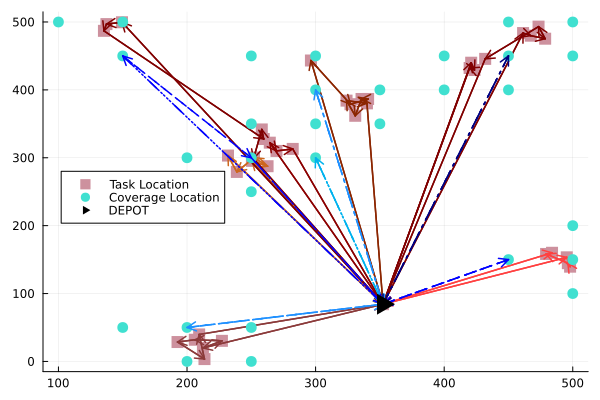

In [53]:
x_values = []
y_values = []
for i in 2:length(job_locs)
    push!(x_values, job_locs[i][1])
    push!(y_values, job_locs[i][2])
end

scatter(x_values, y_values; label = "Task Location", markershape = :square, 
markercolor = :pink3, markersize = 6, markerstrokecolor = :pink3, markerstrokewidth = 3)

xcs = []
ycs = []
xvecs = []
yvecs = []
# now, the arrows to indicate routes
job_nodes = extract_valid_route_nodes(last_z, job_routes)
for route_node_series in job_nodes
    xc, yc, xv, yv = [], [], [], []
    for index in 1:length(route_node_series)-1
        lindex1 = 1 + route_node_series[index] % (n_jobs+1)
        lindex2 = 1 + route_node_series[index+1] % (n_jobs+1)
        x1, y1 = job_locs[lindex1]
        x2, y2 = job_locs[lindex2]
        push!(xc, x1); push!(yc, y1); push!(xv, x2-x1); push!(yv, y2-y1)
    end
    push!(xcs, xc); push!(ycs, yc); push!(xvecs, xv); push!(yvecs, yv)
end

colors = [:orangered4, :maroon, :chocolate3, :brown1, :indianred4, :maroon, :red4]
for i in 1:length(xcs)
    quiver!(xcs[i], ycs[i], quiver = (xvecs[i], yvecs[i]), linewidth=1.5, c=colors[i % length(colors) + 1])
end

cov_x = []
cov_y = []
for i in 1:length(cov_locs)
    push!(cov_x, cov_locs[i][1])
    push!(cov_y, cov_locs[i][2])
end

scatter!(cov_x, cov_y; label = "Coverage Location", markershape = :circle,
markercolor = :turquoise, markersize = 6, markerstrokecolor = :turquoise, markerstrokewidth=3)

covxs = []
covys = []
covecx = []
covecy = []
cov_nodes = extract_valid_route_nodes(last_x, cov_routes)
for route_node_series in cov_nodes
    xc, yc, xv, yv = [], [], [], []
    for index in 1:length(route_node_series)-1
        lindex1 = 1 + route_node_series[index] % (m_cov+1)
        lindex2 = 1 + route_node_series[index+1] % (m_cov+1)
        x1, y1 = cov_locs[lindex1]
        x2, y2 = cov_locs[lindex2]
        push!(xc, x1); push!(yc, y1); push!(xv, x2-x1); push!(yv, y2-y1)
    end
    push!(covxs, xc); push!(covys, yc); push!(covecx, xv); push!(covecy, yv)
end

covcolors = [:blue1, :dodgerblue, :deepskyblue2, :dodgerblue, :blue1, :navyblue]
for i in 1:length(covxs)
    quiver!(covxs[i], covys[i], quiver = (covecx[i], covecy[i]), linewidth=1.5, c=covcolors[i % length(covcolors) + 1], linestyle=:dashdotdot)
end

display(scatter!([job_locs[1][1]], [job_locs[1][2]]; label = "DEPOT", markershape = :rtriangle,
markercolor = :black, markersize = 15, markerstrokecolor = :black, legend=:left))

## [12.2] Properties of Solution

### [12.2.1] Ratio of Job to Coverage Distance

In [54]:
println("Ratio of Job to Cov Distance: ", job_dist/cov_dist)

Ratio of Job to Cov Distance: 1.6377066038035502


### [12.2.2] Number of Job and Coverage Vehicles

In [55]:
job_useful_routes = extract_useful_routes(job_routes, last_z);

In [56]:
cov_useful_routes = extract_useful_routes(cov_routes, last_x);

In [57]:
println("Number of Job Vehicles: ", length(job_useful_routes))
println("Number of Coverage Vehicles: ", length(cov_useful_routes))

Number of Job Vehicles: 8
Number of Coverage Vehicles: 6


### [12.2.3] Number of Jobs per Route

In [58]:
num_jobs_per_route = [length(route_to_nodes(route)) - 2 for route in job_useful_routes]
println(num_jobs_per_route)

[5, 5, 5, 6, 3, 3, 7, 6]


### [12.2.4] Time Spent per Job Vehicle Working at Jobs

In [59]:
time_working = [sum(work_load[route_to_nodes(route)[index]] for index in 2:length(route_to_nodes(route))-1) for route in job_useful_routes]

println(time_working)

[13, 13, 18, 18, 12, 6, 20, 16]


### [12.2.5] Number of Coverage Spots per Coverage Route

In [60]:
num_covs_per_route = [length(route_to_nodes(route)) - 2 for route in cov_useful_routes]
println(num_covs_per_route)

[1, 1, 1, 1, 1, 2]


## [12.4] Greedy Solution

In [61]:
function jobs_sorted_by_distance(index1, posses)
    # Always use job number, depot = 0.
    x, y = job_locs[index1+1]
    candidates = Dict()
    for cand in posses
        cand_job = job_locs[cand+1]
        candidates[cand] = ((cand_job[1]-x)^2+(cand_job[2]-y)^2)^0.5
    end
    return sort(collect(candidates), by = x -> x[2])
end;

In [62]:
function closest_cov_to_job(job, old_cov)
    # Again, depot = 0
    
    new_covs = close_covs(job)
    x, y = cov_locs[old_cov+1]
    candidates = Dict()
    for cand in new_covs
        cand_cov = cov_locs[cand+1]
        candidates[cand] = ((cand_cov[1]-x)^2+(cand_cov[2]-y)^2)^0.5
    end
    return sort(collect(candidates), by = x -> x[2])[1][1]
end;

In [63]:
unused = [i for i in 1:n_jobs]
greedy_sum_jobs = 0
greedy_sum_cov = 0
job_routes_g = []
job_times_g = []
cov_routes_g = []
cov_times_g = []

while length(unused) > 0
    can_continue = true
    prev_candidate = 0
    old_cov = 0
    cur_time = 0
    job_route = [0]
    cov_route = [0]
    while can_continue
        possibilities = jobs_sorted_by_distance(prev_candidate, unused)
        found_possibility = false
        for possibility in possibilities
            poss_job_index = possibility[1]
            time_add = job_travel_times[prev_candidate+1, poss_job_index+1]
            
            if cur_time + time_add + work_load[poss_job_index] <= time_windows[poss_job_index][2]
                cur_time += time_add + work_load[poss_job_index]
                
                greedy_sum_jobs += job_dists[prev_candidate+1, poss_job_index+1]
                
                poss_job_loc = job_locs[poss_job_index+1]
                
                cov_new = closest_cov_to_job(poss_job_index, old_cov)
                greedy_sum_cov += cov_dists[cov_new+1, old_cov+1]
                prev_candidate = poss_job_index
                old_cov = cov_new
                
                found_possibility = true
                
                deleteat!(unused, findall(x -> x == poss_job_index, unused))
                
                push!(job_route, poss_job_index)
                if cov_new != last(cov_route)
                    push!(cov_route, cov_new)
                end
                break
            end
        end
        
        can_continue = found_possibility
    end
    
    greedy_sum_jobs += job_dists[job_route[end]+1, n_jobs+1+1]
    greedy_sum_cov += cov_dists[cov_route[end]+1, m_cov+1+1]
    
    push!(job_route, n_jobs+1)
    push!(cov_route, m_cov+1)
        
    push!(job_routes_g, job_route)
    push!(cov_routes_g, cov_route)
end

## [12.5] Properties of Greedy Solution

In [64]:
println("Job Distance: ", greedy_sum_jobs)
println("Cov Distance: ", greedy_sum_cov)
println("Total Distance: ", greedy_sum_jobs + greedy_sum_cov)

Job Distance: 7524.53868958963
Cov Distance: 6612.1209239367145
Total Distance: 14136.659613526344


### [12.5.1] Ratio of Job to Coverage Distance

In [65]:
println("Ratio of Job to Cov Distance: ", greedy_sum_jobs/greedy_sum_cov)

Ratio of Job to Cov Distance: 1.1379916937619587


### [12.5.2] Number of Job and Coverage Vehicles

In [66]:
println("Number of Job Vehicles: ", length(job_routes_g))
println("Number of Coverage Vehicles: ", length(cov_routes_g))

Number of Job Vehicles: 8
Number of Coverage Vehicles: 8


### [12.5.3] Number of Jobs per Route

In [67]:
num_jobs_per_route = [length(route) - 2 for route in job_routes_g]
println(num_jobs_per_route)

[11, 8, 7, 5, 4, 3, 1, 1]


### [12.5.4] Time Spent per Job Vehicle Working at Jobs

In [68]:
time_working = [sum(work_load[route[index]] for index in 2:length(route)-1) for route in job_routes_g]

println(time_working)

[28, 28, 17, 14, 13, 9, 4, 3]


### [12.5.5] Number of Coverage Spots per Coverage Route

In [69]:
num_covs_per_route = [length(route) - 2 for route in cov_routes_g]
println(num_covs_per_route)

[6, 4, 4, 5, 2, 2, 1, 1]


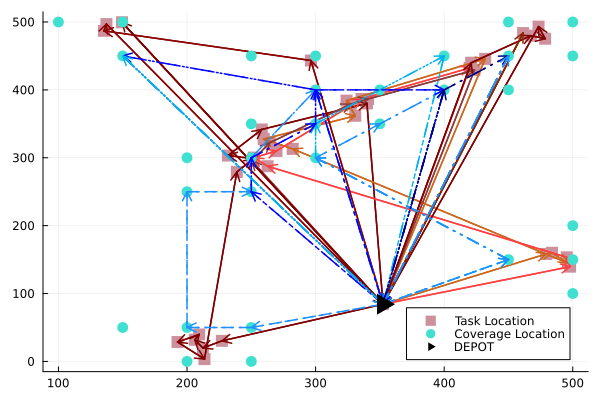

In [70]:
x_values = []
y_values = []
for i in 2:length(job_locs)
    push!(x_values, job_locs[i][1])
    push!(y_values, job_locs[i][2])
end

scatter(x_values, y_values; label = "Task Location", markershape = :square, 
markercolor = :pink3, markersize = 6, markerstrokecolor = :pink3, markerstrokewidth = 3)

xcs = []
ycs = []
xvecs = []
yvecs = []
# now, the arrows to indicate routes
job_nodes = job_routes_g
for route_node_series in job_nodes
    xc, yc, xv, yv = [], [], [], []
    for index in 1:length(route_node_series)-1
        lindex1 = 1 + route_node_series[index] % (n_jobs+1)
        lindex2 = 1 + route_node_series[index+1] % (n_jobs+1)
        x1, y1 = job_locs[lindex1]
        x2, y2 = job_locs[lindex2]
        push!(xc, x1); push!(yc, y1); push!(xv, x2-x1); push!(yv, y2-y1)
    end
    push!(xcs, xc); push!(ycs, yc); push!(xvecs, xv); push!(yvecs, yv)
end

colors = [:orangered4, :maroon, :chocolate3, :brown1, :indianred4, :maroon, :red4]
for i in 1:length(xcs)
    quiver!(xcs[i], ycs[i], quiver = (xvecs[i], yvecs[i]), linewidth=1.5, c=colors[i % length(colors) + 1])
end

cov_x = []
cov_y = []
for i in 1:length(cov_locs)
    push!(cov_x, cov_locs[i][1])
    push!(cov_y, cov_locs[i][2])
end

scatter!(cov_x, cov_y; label = "Coverage Location", markershape = :circle,
markercolor = :turquoise, markersize = 6, markerstrokecolor = :turquoise, markerstrokewidth=3)

covxs = []
covys = []
covecx = []
covecy = []
cov_nodes = cov_routes_g
for route_node_series in cov_nodes
    xc, yc, xv, yv = [], [], [], []
    for index in 1:length(route_node_series)-1
        lindex1 = 1 + route_node_series[index] % (m_cov+1)
        lindex2 = 1 + route_node_series[index+1] % (m_cov+1)
        x1, y1 = cov_locs[lindex1]
        x2, y2 = cov_locs[lindex2]
        push!(xc, x1); push!(yc, y1); push!(xv, x2-x1); push!(yv, y2-y1)
    end
    push!(covxs, xc); push!(covys, yc); push!(covecx, xv); push!(covecy, yv)
end

covcolors = [:blue1, :dodgerblue, :deepskyblue2, :dodgerblue, :blue1, :navyblue]
for i in 1:length(covxs)
    quiver!(covxs[i], covys[i], quiver = (covecx[i], covecy[i]), linewidth=1.5, c=covcolors[i % length(covcolors) + 1], linestyle=:dashdotdot)
end

display(scatter!([job_locs[1][1]], [job_locs[1][2]]; label = "DEPOT", markershape = :rtriangle,
markercolor = :black, markersize = 15, markerstrokecolor = :black, legend=:bottomright))

## [12.6] Jobs-Cov Solution

In [71]:
job_routes, last_z, job_objective = colgen_jobs_alone(job_routes, job_dists, job_travel_times, time_windows, work_load);
println(job_objective)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-18
5282.408786181387


In [72]:
cov_routes, last_x, cov_objective = colgen_cov_only(cov_routes, job_routes, cov_dists, cov_travel_times, last_z);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-18


In [73]:
job_dist = recover_z_obj(last_z, job_routes)
println("Jobs Distance: ", job_dist)

Jobs Distance: 5282.408786181387


In [74]:
cov_dist = recover_x_obj(last_x, cov_routes)
println("Cov Distance: ", cov_dist)

Cov Distance: 3225.4915342669237


In [75]:
println("Total Objective for Optimization: ", job_dist+cov_dist)

Total Objective for Optimization: 8507.90032044831


In [76]:
println("Z VALUES")
for z in last_z
    if z > 1e-4
        print(round(z, digits=1), " ")
    end
end

Z VALUES
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 

In [77]:
println("X VALUES")
for x in last_x
    if x > 1e-4
        print(round(x, digits=1), " ")
    end
end

X VALUES
1.0 1.0 1.0 1.0 1.0 1.0 

## [12.7] Properties of Jobs-Cov Solution

### [12.7.1] Ratio of Job to Coverage Distance

In [78]:
println("Ratio of Job to Cov Distance: ", job_dist/cov_dist)

Ratio of Job to Cov Distance: 1.6377066038035504


### [12.7.2] Number of Job and Coverage Vehicles

In [79]:
job_useful_routes = extract_useful_routes(job_routes, last_z);

In [80]:
cov_useful_routes = extract_useful_routes(cov_routes, last_x);

In [81]:
println("Number of Job Vehicles: ", length(job_useful_routes))
println("Number of Coverage Vehicles: ", length(cov_useful_routes))

Number of Job Vehicles: 8
Number of Coverage Vehicles: 6


### [12.7.3] Number of Jobs per Route

In [82]:
num_jobs_per_route = [length(route_to_nodes(route)) - 2 for route in job_useful_routes]
println(num_jobs_per_route)

[5, 5, 5, 6, 3, 7, 3, 6]


### [12.7.4] Time Spent per Job Vehicle Working at Jobs

In [83]:
time_working = [sum(work_load[route_to_nodes(route)[index]] for index in 2:length(route_to_nodes(route))-1) for route in job_useful_routes]

println(time_working)

[13, 13, 18, 18, 6, 20, 12, 16]


### [12.7.5] Number of Coverage Spots per Coverage Route

In [84]:
num_covs_per_route = [length(route_to_nodes(route)) - 2 for route in cov_useful_routes]
println(num_covs_per_route)

[1, 1, 1, 1, 1, 2]


## [12.8] Jobs-Follow Solution

In [85]:
job_routes, last_z, job_objective = colgen_jobs_alone(job_routes, job_dists, job_travel_times, time_windows, work_load);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-18


In [86]:
job_routes_follow = [job_routes[index] for index in 1:length(job_routes) if last_z[index] >= 1e-4];

In [87]:
greedy_sum_cov = 0
cov_routes_g = []
total_dist_cov = 0

for route in job_routes_follow
    route_nodes = route_to_nodes(route)
    println(route_nodes)
    cov_route = [0]
    old_cov = 0
    for index in 2:length(route_nodes)-1
        job_curr = route_nodes[index]
        cov_new = closest_cov_to_job(job_curr, old_cov)
        total_dist_cov += cov_dists[old_cov+1, cov_new+1]
        if old_cov != cov_new
            push!(cov_route, cov_new)
        end
        old_cov = cov_new
    end
    total_dist_cov += cov_dists[last(cov_route)+1, m_cov+2]
    push!(cov_route, m_cov+1)
    push!(cov_routes_g, cov_route)
end;

Any[0, 30, 31, 32, 33, 18, 41]
Any[0, 24, 25, 26, 27, 28, 41]
Any[0, 1, 2, 3, 4, 5, 41]
Any[0, 9, 10, 11, 12, 13, 14, 41]
Any[0, 19, 20, 22, 41]
Any[0, 40, 34, 35, 36, 37, 38, 39, 41]
Any[0, 15, 16, 17, 41]
Any[0, 6, 7, 8, 21, 23, 29, 41]


In [88]:
cov_routes_g

8-element Vector{Any}:
 [0, 25, 32]
 [0, 11, 12, 32]
 [0, 23, 32]
 [0, 10, 6, 32]
 [0, 15, 32]
 [0, 17, 32]
 [0, 21, 32]
 [0, 3, 13, 12, 32]

In [89]:
println("Total Jobs Distance: ", job_dist)

Total Jobs Distance: 5282.408786181387


In [90]:
println("Total Coverage Distance: ", total_dist_cov)

Total Coverage Distance: 4360.402345765894


In [91]:
println("Total Distance: ", job_dist + total_dist_cov)

Total Distance: 9642.811131947281


In [92]:
println("Job/Cov Distance Ratio: ", job_dist / total_dist_cov)

Job/Cov Distance Ratio: 1.2114498542343906


In [93]:
println("Job Vehicles: ", length(job_useful_routes))
println("Cov Vehicles: ", length(cov_routes_g))

Job Vehicles: 8
Cov Vehicles: 8


### [12.8.5] Number of Coverage Spots per Coverage Route

In [94]:
num_covs_per_route = [length(route) - 2 for route in cov_routes_g]
println(sort!(num_covs_per_route))

[1, 1, 1, 1, 1, 2, 2, 3]
